# CTRNN - An Interesting Acronym

We will be searching for a CTRNN that produces cyclic behavior in neuron
activations by using an evolutionary algorithm.

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ctrnn import CTRNN

### Evolutionary search algorithm to find cyclic activations

In [2]:
class EvolutionaryCTRNN():
    def __init__(self, dt, fitness_steps, n_neurons, popsize, recomb_prob,
                 mutat_std):
        self.dt = dt
        self.fitness_steps = fitness_steps
        self.n_neurons = n_neurons
        self.popsize = popsize
        self.recomb_prob = recomb_prob
        self.mutate_std = mutate_std 
        self.pop = np.array(
            [CTRNN(self.n_neurons, dt=self.dt) for _ in range(self.popsize)]
        )
        
    def attempt_cycles(self, c):
        """
        c : CTRNN
        
        The activations of c over self.fitness_steps points in time
        """
        # Activations of the CTRNN neurons at each point in time
        activations = np.zeros((self.n_neurons, self.fitness_steps))
        for t in range(self.fitness_steps):
            activations[:,t] = c.activations
            c.step()
        return activations
        
    def fitness(self, c):
        """
        c : CTRNN
        
        The fitness of a CTRNN based on time_steps many steps to attempt to
        produce a cycle.
        """
        activations = self.attempt_cycles(c)
            
        # Differences at each point in time.
        # differentials[i,j] = | acitvations[i,j+1] - activations[i,j] |
        differentials = np.abs(activations[:,1:] - activations[:,:-1])
        # Want to normalize by number of neurons and length of time interval
        return np.sum(differentials) / (self.n_neurons)

    def best_ctrnn(self):
        """
        The fittest CTRNN in the population.
        """
        best = None
        best_fitness = float("-inf")
        for c in self.pop:
            if self.fitness(c) > best_fitness:
                best = c
        return best
    
    def best_fitness(self):
        """
        The fitness value for the fittest CTRNN in the population.
        Modeled after code used in class and for lab assignments.
        """
        return np.max([self.fitness(c) for c in self.pop])

    def run_tournament(self):
        """
        Pick two individuals and make them compete for survival of their genes.
        Modeled after code used in class and for lab assignments.
        """
        # 1. Pick two distinct members of population
        a, b = np.random.choice(self.pop, 2, replace=False)
        
        # 2. Compare fitness
        if self.fitness(a) > self.fitness(b):
            winner = a
            loser = b
        else:
            winner = b
            loser = a
        
        # 3. Transfect loser with winner
        for i in range(loser.N):
            for j in range(loser.N):
                # Transfect weights
                if np.random.random() < self.recomb_prob:
                    loser.weights[i,j] = winner.weights[i,j]
            # Transfect biases
            if np.random.random() < self.recomb_prob:
                loser.biases[i] = winner.biases[i]
            # Transfect time_constants
            if np.random.random() < self.recomb_prob:
                loser.time_constants[i] = winner.time_constants[i]
        
        # 4. Mutate loser, clip time_constants to within desired range
        loser.weights += np.random.normal(0.0, self.mutate_std,
                                          size=(loser.N, loser.N))
        loser.biases += np.random.normal(0.0, self.mutate_std, size=loser.N)
        loser.time_constants += np.random.normal(0.0, self.mutate_std,
                                                 size=loser.N)
        # loser.weights = np.clip(loser.weights, 0.0, float("inf"))
        # loser.biases = np.clip(loser.biases, 0.0, float("inf"))
        loser.time_constants = np.clip(loser.time_constants,
                                       10.0 * self.dt, 100.0 * self.dt)
    
    def search_for_cycles(self, generations=100, update_every=float("inf")):
        """
        generations : int
        update_every : int
          float("inf") as default value means that it will never print anything.
         
        Search for cycles using an evolutionary search algorithm.
        Modeled after code used in class and for lab assignments.
        """
        best_fit_hist = np.zeros(generations)
        
        for i in range(generations):
            if i % update_every == 0: print(i, end=" ")
            for j in range(self.popsize):
                self.run_tournament()
            best_fit_hist[i] = self.best_fitness()
        
        return self.best_ctrnn()

0 100 200 300 400 500 600 700 800 900 

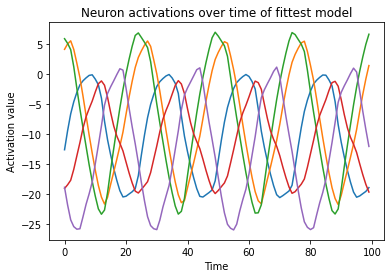

In [6]:
dt = 0.1
fitness_steps = 100
n_neurons = 5
popsize = 10
recomb_prob = 0.5
mutate_std = 0.5

generations = 1000

e = EvolutionaryCTRNN(dt, fitness_steps, n_neurons, popsize, recomb_prob,
                       mutate_std)
c = e.search_for_cycles(generations=generations, update_every=100)
activations = e.attempt_cycles(c)

for i in range(n_neurons):
    plt.plot(activations[i,:])

plt.xlabel("Time")
plt.ylabel("Activation value")
plt.title("Neuron activations over time of fittest model")
plt.show()